In [1]:
import torch
import os
import torch.nn.functional as F
from torch import Tensor
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm, trange
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pymystem3
tqdm.pandas()
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report
import scipy
from transformers import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader

In [32]:
path = "../../data/"
data = pd.read_csv(path + 'train_events.csv')
video = pd.read_csv(path + 'video_info_v2.csv')
targets = pd.read_csv(path + 'train_targets.csv')

# Big model embeds

Тут были эксперименты с эмбеддингами

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

# tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
# model = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')
tokenizer = AutoTokenizer.from_pretrained('Alibaba-NLP/gte-Qwen2-1.5B-instruct')
model = AutoModel.from_pretrained('Alibaba-NLP/gte-Qwen2-1.5B-instruct')

device_ids = [3, 1, 2]
model = nn.DataParallel(model, device_ids=device_ids)
n_gpu = len(device_ids)

model.to(f"cuda:{device_ids[0]}")
print(model.device_ids)


max_length = 128
def tokenize(texts):
    tensors = tokenizer(texts, max_length=max_length, padding=True, truncation=True, return_tensors="pt")
    return {k : v for k, v in tensors.items()}

def embed(texts):
    with torch.no_grad():
        t = tokenize(texts)
        
        last_state = model(**t).last_hidden_state
        return last_token_pool(last_state, t["attention_mask"])

def embed_batched(texts, bs=128):
    n = len(texts)
    res = []
    for i in trange(0, n, bs):
        res.append(embed(texts[i:i+bs]))
    return list(torch.cat(res).cpu().numpy().squeeze())

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[3, 1, 2]


In [4]:
video['text'] = video.apply(lambda x: 'Название видео: "' + x['title'] + '"; Категория видео: ' + x['category'], axis=1)
video['query'] = video['text'].apply(lambda x: get_detailed_instruct("Определи средний возраст целевой аудитории данного видео", x))
embeds_large = embed_batched(list(video['query']))

In [40]:
def reduce_dimensionality(data, target_dimension=32):
    """
    Уменьшает размерность данных с d до target_dimension с помощью PCA.

    Args:
        data (numpy.ndarray): Исходные данные размерности (n_samples, d).
        target_dimension (int): Желаемая размерность выходных данных. По умолчанию 32.

    Returns:
        numpy.ndarray: Данные размерности (n_samples, target_dimension).
    """
    # Инициализируем PCA с целевой размерностью
    pca = PCA(n_components=target_dimension)
    
    # Применяем PCA к данным
    reduced_data = pca.fit_transform(data)
    
    return reduced_data

embeds_64_weak = reduce_dimensionality(embeds_large, target_dimension=64)

## autoencoder

Пробовали сжимать эмбеддинги не только с помощью k-means, но и с помощью автоэнкодеров. Получилось хуже, чем с исходными эмбеддингами

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1536, 64),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 1536),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


data = torch.tensor(np.array(embeds_large))

# Создание DataLoader'ов для тренировки и валидации
dataset = TensorDataset(data, data)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Функция тренировки модели
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    for data in tqdm(train_loader):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

# Функция валидации модели
def validate_epoch(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(val_loader):
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()
    return val_loss / len(val_loader)


num_epochs = 8
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = validate_epoch(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Построение графика ошибок
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
data = torch.tensor(np.array(embeds_large))

In [22]:
outputs = []
with torch.no_grad():
    model.eval()
    for input in tqdm(data):
        input = input.to(device)
        output = model.encoder(input)
        outputs.append(output.cpu().numpy())

100%|██████████| 481480/481480 [01:45<00:00, 4574.90it/s]


In [30]:
embeds_64 = np.load('data/embeds_large_64_v1.npy')

# Normalize

In [33]:
video['text'] = video.apply(lambda x: x['title'] + f' Категория: {x['category']}', axis=1)
video['duration_sec'] = video['duration'] // 1000
#video['embeds'] = list(embeds)
video['embeds_64'] = list(embeds_64)
targets['sex'] = targets['sex'].apply(lambda x: 0 if x == 'male' else 1)
data = data.merge(video, on='rutube_video_id', how='inner')
data = data.merge(targets, on='viewer_uid', how='inner')
data['count'] = data.groupby('viewer_uid')['viewer_uid'].transform('count')
data['part_wached'] = data['total_watchtime'] / data['duration_sec']
data = data.sort_values(by='event_timestamp')

# TF-IDF

Извлекали слова различной частотности из текста. В итоге в окончательное решение пошли популярные слова

In [5]:
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')
stemmer = pymystem3.Mystem()


def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление ненужных символов
    text = re.sub(r'[^a-zа-яё0-9\s]', '', text)
    text = ''.join(stemmer.lemmatize(text))
    return text


data['cleaned_text'] = data['text'].progress_apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/kuzakov-
[nltk_data]     dn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 1759616/1759616 [07:26<00:00, 3940.89it/s]


In [6]:
# Создание tf-idf векторов
tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords, min_df=0.001, max_df=0.1)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])
data['tf_idf_embeds'] = list(tfidf_matrix)

In [ ]:
tfidf_vectorizer.get_feature_names_out()

# Sum embeds

Суммировали эмбеддинги по всем видосам с коэффициентами, пропорциональными длительности просмотра видео

In [35]:
# Усредняем с коэффициентами
def custom_aggregation(df):
    coeffs = np.array(df['part_wached'])
    coeffs /= np.linalg.norm(coeffs)
    return np.sum([coef * vec for vec, coef in zip(df['embeds_64'], coeffs)], axis=0)

def custom_aggregation_tf_idf(df):
    coeffs = np.array(df['part_wached'])
    coeffs /= np.linalg.norm(coeffs)
    return np.sum([coef * vec for vec, coef in zip(df['tf_idf_embeds'], coeffs)], axis=0)

def no_aggregation(df):
    return np.array(df['embeds_64'])

# print('tf_idf')
# users_embeds_tf_idf = data.groupby('viewer_uid').apply(custom_aggregation_tf_idf)
print('embeds')
users_embeds = data.groupby('viewer_uid').apply(custom_aggregation)
print('embeds_all')
users_embeds_all = data.groupby('viewer_uid').apply(no_aggregation)

users_embeds.name = 'embeds_64'
users_embeds_all.name = 'embeds_all'
#users_embeds_tf_idf.name = 'embed_tf_idf'

targets = pd.merge(users_embeds, targets, on='viewer_uid', how='inner')
targets = pd.merge(users_embeds_all, targets, on='viewer_uid', how='inner')
#targets = pd.merge(users_embeds_tf_idf, targets, on='viewer_uid', how='inner')

embeds


/var/tmp/ipykernel_5414/1450419632.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  users_embeds = data.groupby('viewer_uid').apply(custom_aggregation)


embeds_all


/var/tmp/ipykernel_5414/1450419632.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  users_embeds_all = data.groupby('viewer_uid').apply(no_aggregation)


# Models

## BERT

Пробовали обучить берт на склеенных названиях видео, но не особо вышло

In [114]:
train_ids, test_ids = train_test_split(targets['viewer_uid'], test_size=0.5, random_state=42)
test_ids = test_ids.sample(10000)

X_train = data[data.viewer_uid.isin(train_ids)]
X_train = X_train.groupby('viewer_uid').agg(
    texts=('text', lambda x: '; '.join(x))
).reset_index().sort_values(by='viewer_uid')['texts']
y_train = data[data.viewer_uid.isin(train_ids)].drop_duplicates(subset='viewer_uid').sort_values(by='viewer_uid')['age_class']
X_test = data[data.viewer_uid.isin(test_ids)]
X_test = X_test.groupby('viewer_uid').agg(
    texts=('text', lambda x: '; '.join(x))
).reset_index().sort_values(by='viewer_uid')['texts']
y_test = data[data.viewer_uid.isin(test_ids)].drop_duplicates(subset='viewer_uid').sort_values(by='viewer_uid')['age_class']

In [ ]:
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=4)

def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=400)

X_train_tokenised = [tokenize_function(text) for text in X_train]
X_test_tokenised = [tokenize_function(text) for text in X_test]

# Создание класса Dataset
class TextDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.encodings = tokenized_texts
        self.labels = labels.to_numpy()

    def __getitem__(self, idx):
        encoding = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item = {**encoding, 'labels': torch.tensor(self.labels[idx])}
        return item

    def __len__(self):
        return len(self.labels)

# Создание датасетов
train_encodings = {key: [d[key] for d in X_train_tokenised] for key in X_train_tokenised[0]}
test_encodings = {key: [d[key] for d in X_test_tokenised] for key in X_test_tokenised[0]}

train_dataset = TextDataset(train_encodings, y_train)
test_dataset = TextDataset(test_encodings, y_test)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(3):  # Например, 3 эпохи
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch} loss: {loss.item()}")

    # Оценка модели
    model.eval()
    correct = 0
    total = 0

    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            _, predicted = torch.max(outputs.logits, 1)
            total += batch['labels'].size(0)
            correct += (predicted == batch['labels']).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(batch['labels'].cpu().numpy())

    print(f'Accuracy: {100 * correct / total}%')
    print(f'F1: {100 * f1_score(y_true, y_pred, average='weighted')}%')

In [117]:
y_true = []
y_pred = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch['labels'].cpu().numpy())

print(f'Accuracy: {100 * correct / total}%')
print(f'F1: {100 * f1_score(y_true, y_pred, average='weighted')}%')

100%|██████████| 313/313 [00:52<00:00,  5.97it/s]

Accuracy: 46.68%
F1: 44.88394455065781%


# simple nets

## Reverse подход: по 1 видео предсказание возраста, а затем усреднение

Идея: предсказываем по эмбеддингу видео таргет, а потом берём моду или усредняем таргеты. Идея не сработала

In [ ]:
train_ids, test_ids = train_test_split(targets['viewer_uid'], test_size=0.3, random_state=42)

X_train = np.stack(data[data.viewer_uid.isin(train_ids)]['embeds_32'])
#X_train = np.squeeze(np.stack([i.toarray() for i in X_train]))
y_train = data[data.viewer_uid.isin(train_ids)]['age_class']
X_test = np.stack(data[data.viewer_uid.isin(test_ids)]['embeds_32'])
#X_test = np.squeeze(np.stack([i.toarray() for i in X_test]))
y_test = data[data.viewer_uid.isin(test_ids)]['age_class']

In [102]:
log_reg_age = LogisticRegression(max_iter=1000)
log_reg_age.fit(X_train, y_train)
y_pred_age = log_reg_age.predict(X_test)

In [103]:
print("Classification report for age prediction:")
print(classification_report(y_test, y_pred_age))

Classification report for age prediction:


/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20263
           1       0.44      0.52      0.47    195035
           2       0.40      0.52      0.45    202920
           3       0.47      0.16      0.24    109220

    accuracy                           0.42    527438
   macro avg       0.33      0.30      0.29    527438
weighted avg       0.41      0.42      0.40    527438



/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
data_predict = data[data['viewer_uid'].isin(test_ids)]
data_predict['preds_one'] = log_reg_age.predict(np.stack(data_predict['embeds_32']))
preds_all = data_predict.groupby('viewer_uid').agg(
    preds_all=('preds_one', lambda x: x.value_counts().idxmax())
)
preds_all = preds_all.merge(targets[['viewer_uid', 'age_class']], on='viewer_uid')

In [110]:
print("Classification report for age prediction:")
print(classification_report(preds_all['age_class'], preds_all['preds_all']))

Classification report for age prediction:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2280
           1       0.43      0.44      0.44     18967
           2       0.39      0.58      0.46     19692
           3       0.47      0.19      0.27     13065

    accuracy                           0.41     54004
   macro avg       0.32      0.30      0.29     54004
weighted avg       0.41      0.41      0.39     54004



/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## linear

Просто линейные модели по эмбеддингам пользователей

In [38]:
# Создание признаков и целевых переменных
#X = np.concatenate((np.squeeze(np.stack([i.toarray() for i in targets['embed_tf_idf']])), np.stack(targets['embed'])), axis=1)
X = np.squeeze(np.stack(targets['embeds_64']))
y = targets[['viewer_uid', 'sex', 'age_class', 'age']]

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [39]:
# Логистическая регрессия для предсказания пола
log_reg_gender = LogisticRegression(max_iter=1000)
log_reg_gender.fit(X_train, y_train['sex'])
y_pred_gender = log_reg_gender.predict(X_test)

print("Classification report for gender prediction:")
print(classification_report(y_test['sex'], y_pred_gender))

# Логистическая регрессия для предсказания возраста
log_reg_age = LogisticRegression(max_iter=1000)
log_reg_age.fit(X_train, y_train['age_class'])
y_pred_age = log_reg_age.predict(X_test)

print("Classification report for age prediction:")
print(classification_report(y_test['age_class'], y_pred_age))

Classification report for gender prediction:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74     35900
           1       0.76      0.69      0.72     36105

    accuracy                           0.73     72005
   macro avg       0.74      0.73      0.73     72005
weighted avg       0.74      0.73      0.73     72005

Classification report for age prediction:
              precision    recall  f1-score   support

           0       0.42      0.00      0.01      2992
           1       0.43      0.63      0.51     25032
           2       0.41      0.38      0.39     26458
           3       0.47      0.29      0.36     17523

    accuracy                           0.43     72005
   macro avg       0.43      0.33      0.32     72005
weighted avg       0.43      0.43      0.41     72005



# catboost

In [41]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
# CatBoost для предсказания пола
catboost_gender = CatBoostClassifier(iterations=1000, verbose=150)
catboost_gender.fit(X_train, y_train['sex'], eval_set=(X_val, y_val['sex']))
y_pred_gender = catboost_gender.predict(X_test)

print("Classification report for gender prediction:")
print(classification_report(y_test['sex'], y_pred_gender))

# CatBoost для предсказания возрастной категории
catboost_age = CatBoostClassifier(iterations=1000, verbose=150)
catboost_age.fit(X_train, y_train['age_class'], eval_set=(X_val, y_val['age_class']))
y_pred_age = catboost_age.predict(X_test)

print("Classification report for age prediction:")
print(classification_report(y_test['age_class'], y_pred_age))

# sequential

Обучали нейронку с одним скрытым слоем. Показала себя лучше остальных методов

## age

Epoch [1/10], Loss: 1.1852, Val F1: 0.4403
Epoch [2/10], Loss: 1.1165, Val F1: 0.4482
Epoch [3/10], Loss: 1.1069, Val F1: 0.4455
Epoch [4/10], Loss: 1.1010, Val F1: 0.4492
Epoch [5/10], Loss: 1.0961, Val F1: 0.4432
Epoch [6/10], Loss: 1.0909, Val F1: 0.4517
Epoch [7/10], Loss: 1.0862, Val F1: 0.4492
Epoch [8/10], Loss: 1.0813, Val F1: 0.4508
Epoch [9/10], Loss: 1.0764, Val F1: 0.4531
Epoch [10/10], Loss: 1.0717, Val F1: 0.4537


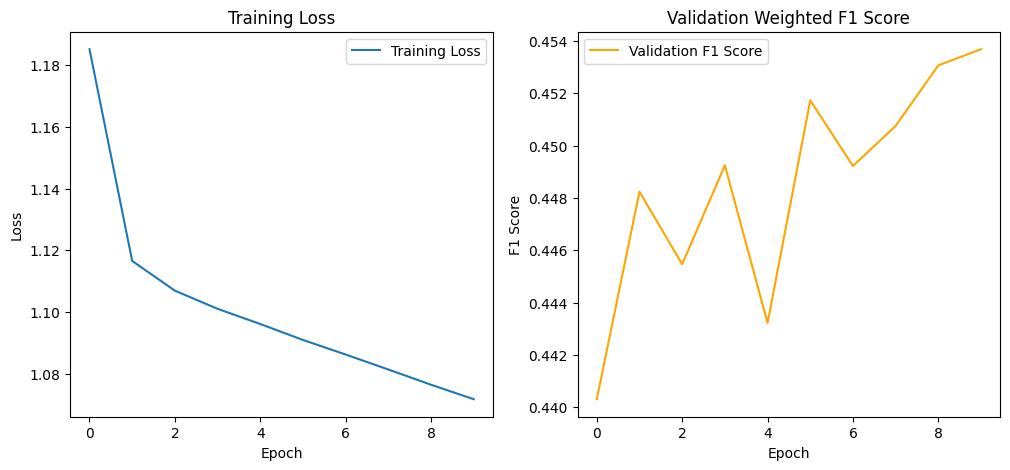

In [15]:
# Устройство (GPU если доступно)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Датасеты и их загрузчики
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(np.array(y_train['age_class']), dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(np.array(y_test['age_class']), dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Определение модели
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры модели
input_size = X_train.shape[1]
hidden_size = 250
num_classes = 4
num_epochs = 10
learning_rate = 0.001

model = SimpleNN(input_size, hidden_size, num_classes).to(device)

# Определение критерия и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_f1_scores = []

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Валидация модели
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    val_f1_scores.append(val_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

# Построение графиков
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation Weighted F1 Score')
plt.legend()

plt.show()

## sex


Epoch [1/10], Loss: 3480.5214, Val accuracy: 0.7384
Epoch [2/10], Loss: 3458.1756, Val accuracy: 0.7416
Epoch [3/10], Loss: 3456.4972, Val accuracy: 0.7426
Epoch [4/10], Loss: 3455.9031, Val accuracy: 0.7409
Epoch [5/10], Loss: 3455.5394, Val accuracy: 0.7416
Epoch [6/10], Loss: 3455.2175, Val accuracy: 0.7428
Epoch [7/10], Loss: 3454.9251, Val accuracy: 0.7408
Epoch [8/10], Loss: 3454.6948, Val accuracy: 0.7422
Epoch [9/10], Loss: 3454.5268, Val accuracy: 0.7429
Epoch [10/10], Loss: 3454.4412, Val accuracy: 0.7421


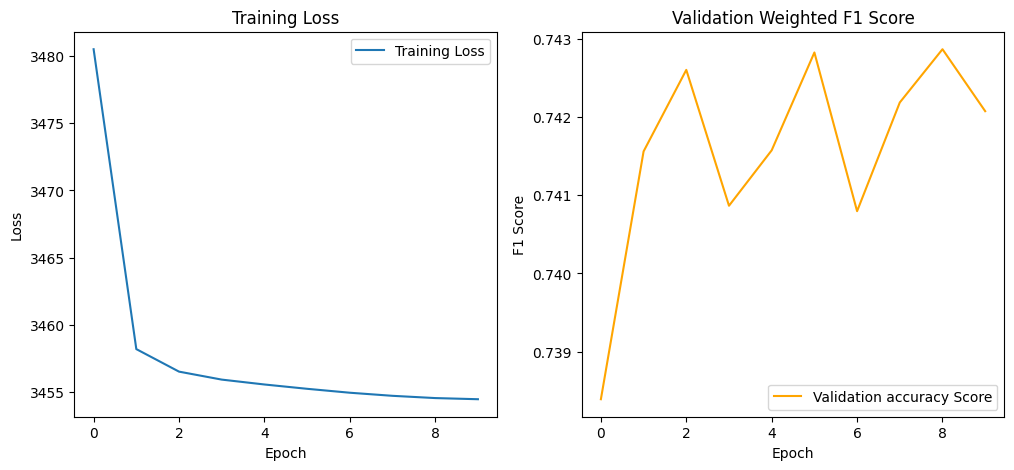

In [14]:
# Устройство (GPU если доступно)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Датасеты и их загрузчики
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(np.array(y_train['sex']), dtype=torch.float))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(np.array(y_test['sex']), dtype=torch.float))

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Определение модели
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out

# Параметры модели
input_size = X_train.shape[1]
hidden_size = 250
num_epochs = 10
learning_rate = 0.001

model = SimpleNN(input_size, hidden_size).to(device)

# Определение критерия и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_f1_scores = []

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Прямой проход
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Валидация модели
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_f1 = accuracy_score(all_labels, all_preds)
    val_f1_scores.append(val_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val accuracy: {val_f1:.4f}")

# Построение графиков
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation accuracy Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.title('Validation Weighted accuracy Score')
plt.legend()

plt.show()

# LSTM

Тоже не до конца изученный вариант, но на первых порах ничего не дал

In [118]:
target_length = 40
embedding_dim = 64
lens = []

# Создадим функцию для обработки каждой последовательности
def pad_or_trim_sequence(seq, target_length):
    seq = np.stack(seq)
    if seq.shape[0] > target_length:
        lens.append(target_length)
        return seq[:target_length]
    else:
        lens.append(seq.shape[0])
        padding = np.zeros((target_length - seq.shape[0], embedding_dim))
        return np.concatenate([seq, padding], axis=0)

# Применим функцию к каждому элементу в колонке embeds_all
targets['embeds_all_alligned'] = targets['embeds_all'].apply(lambda x: pad_or_trim_sequence(x, target_length))
targets['embeds_all_lens'] = lens

In [122]:
# Используем GPU, если он доступен
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Преобразование данных
X = torch.tensor(targets['embeds_all_alligned'].tolist(), dtype=torch.float32)
y = torch.tensor(targets['age_class'].to_numpy(), dtype=torch.long)
lens = torch.tensor(targets['embeds_all_lens'].to_numpy(), dtype=torch.long)

# Разделение данных на обучающие и тестовые
X_train, X_test, y_train, y_test, train_lens, test_lens = train_test_split(X, y, lens, test_size=0.4, random_state=42)

print('1', X_train.size(), y_train.size())

# Создание DataLoader'ов для удобства
train_dataset = TensorDataset(X_train, y_train, train_lens)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test, test_lens)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('2')

# Определение LSTM модели
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x, lens):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # Собираем индексы последних валидных эмбеддингов
        batch_size = x.size(0)
        idx = lens - 1  # последние истинные значения (без padding)
        idx = idx.view(batch_size, 1, 1).expand(batch_size, 1, self.hidden_dim)
        out = out.gather(1, idx).squeeze(1)
        
        out = self.fc(out)
        return out

# Инициализация модели, функции потерь и оптимизатора
embedding_dim = 64
hidden_dim = 64
num_layers = 2
num_classes = 4

model = LSTMClassifier(embedding_dim, hidden_dim, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y, batch_lens in tqdm(train_loader):
        batch_x, batch_y, batch_lens = batch_x.to(device), batch_y.to(device), batch_lens.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x, batch_lens)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

    # Оценка точности модели на тестовых данных
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_x, batch_y, batch_lens in tqdm(test_loader):
            batch_x, batch_y, batch_lens = batch_x.to(device), batch_y.to(device), batch_lens.to(device)
            outputs = model(batch_x, batch_lens)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(batch_y.cpu().numpy())
        accuracy = correct / total
        print(f'Accuracy on test data: {accuracy * 100:.2f}%')
        print(f'F1: {100 * f1_score(y_true, y_pred, average='weighted')}%')

Using device: cuda:3
1 torch.Size([108007, 40, 64]) torch.Size([108007])
2


100%|██████████| 1126/1126 [00:02<00:00, 526.53it/s]


Accuracy on test data: 42.98%
F1: 42.10171548242207%


100%|██████████| 1126/1126 [00:02<00:00, 523.13it/s]


Accuracy on test data: 43.81%
F1: 42.92014767996783%


100%|██████████| 1126/1126 [00:02<00:00, 514.81it/s]


Accuracy on test data: 44.51%
F1: 43.42378265439098%


100%|██████████| 1126/1126 [00:02<00:00, 520.32it/s]


Accuracy on test data: 44.67%
F1: 43.303525277544495%


100%|██████████| 1126/1126 [00:02<00:00, 533.75it/s]


Accuracy on test data: 45.06%
F1: 44.10973694153847%


100%|██████████| 1126/1126 [00:02<00:00, 508.56it/s]


Accuracy on test data: 45.13%
F1: 43.88694387550439%


100%|██████████| 1126/1126 [00:02<00:00, 503.81it/s]


Accuracy on test data: 45.40%
F1: 44.40198920594432%


100%|██████████| 1126/1126 [00:02<00:00, 503.74it/s]


Accuracy on test data: 45.39%
F1: 43.16196837258019%


100%|██████████| 1126/1126 [00:02<00:00, 500.82it/s]


Accuracy on test data: 45.40%
F1: 43.38559017653025%


100%|██████████| 1688/1688 [00:06<00:00, 244.10it/s]


Epoch [10/10], Loss: 1.1078


100%|██████████| 1126/1126 [00:02<00:00, 505.53it/s]

Accuracy on test data: 45.82%
F1: 44.268452793914285%
